## Random Forest

EEC 270 Website Fingerprinting

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [6]:
data = pd.read_csv('data_5.csv')
features = list(data.columns)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('label', axis=1),
    data['label'],
    test_size=0.20
)

## XGBoost

In [9]:
param_dist = {
    'n_estimators': 300,
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
}

xgb = XGBClassifier(**param_dist)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test,y_test)], verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

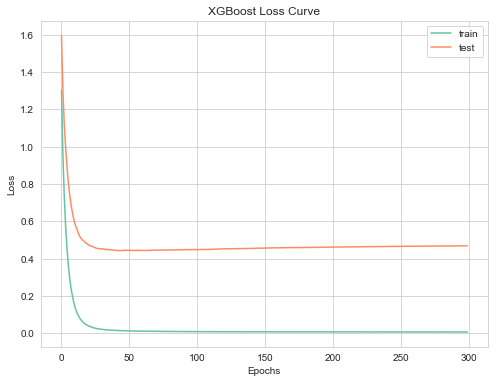

In [10]:
# Loss Curve of mlogloss
results = xgb.evals_result()

plt.figure(figsize=(8, 6))
plt.title('XGBoost Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()

In [11]:
# Multi-fold Verification
scores = cross_val_score(xgb, X_train, y_train, cv=7, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())


Scores: [0.87755102 0.87463557 0.90350877 0.86549708 0.85672515 0.87426901
 0.88304094]
Mean: 0.8764610749419711
Standard Deviation: 0.013595767497775716


In [12]:
# Overall Accuracy
from sklearn.metrics import accuracy_score
pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("Scores:", accuracy)

Scores: 0.8716666666666667


<BarContainer object of 25 artists>

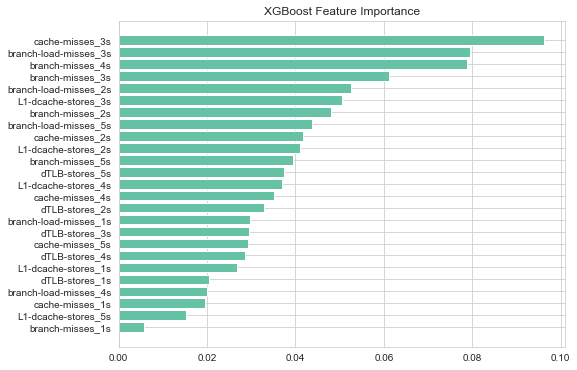

In [13]:
plt.figure(figsize=(8, 6))
plt.title('XGBoost Feature Importance')
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])

### Hyperparameters Tuning

In [18]:
import optuna

def objective(trial):
    params = {
        'n_estimators': 100,
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        
        "booster": trial.suggest_categorical("booster", ["gbtree"]), # "gblinear", "dart",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if params["booster"] == "gbtree" or params["booster"] == "dart":
        params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        params["gamma"] = trial.suggest_loguniform("gamma", 1e-8, 1.0)
        params["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 0, 10)
        params["learning_rate"] = trial.suggest_loguniform("learning_rate", 0.01, 0.2)
        params["subsample"] = trial.suggest_loguniform("subsample", 0.5, 1)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-mlogloss")
    xgb = XGBClassifier(**params)
    xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test,y_test)], verbose=False, callbacks=[pruning_callback])
    pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

study.best_params

[I 2022-03-12 17:40:41,846] A new study created in memory with name: no-name-4700eae9-db94-41b9-adf3-1fe8200795ab
[I 2022-03-12 17:40:47,878] Trial 0 finished with value: 0.785 and parameters: {'booster': 'gbtree', 'lambda': 0.3379268896364806, 'alpha': 5.169347008292461e-07, 'max_depth': 9, 'gamma': 8.965294272129867e-07, 'eta': 1.1165654637153037e-06, 'min_child_weight': 6, 'learning_rate': 0.010644865355208264, 'subsample': 0.5500702218400376}. Best is trial 0 with value: 0.785.
[I 2022-03-12 17:40:52,877] Trial 1 finished with value: 0.8683333333333333 and parameters: {'booster': 'gbtree', 'lambda': 0.006795085563573533, 'alpha': 2.905181891526344e-07, 'max_depth': 4, 'gamma': 0.01173100452732668, 'eta': 9.787057658853043e-08, 'min_child_weight': 7, 'learning_rate': 0.05759375238700754, 'subsample': 0.756068163274751}. Best is trial 1 with value: 0.8683333333333333.
[I 2022-03-12 17:40:55,434] Trial 2 finished with value: 0.84 and parameters: {'booster': 'gbtree', 'lambda': 0.00097

{'booster': 'gbtree',
 'lambda': 2.070016399690929e-06,
 'alpha': 0.002118811852586888,
 'max_depth': 5,
 'gamma': 5.410768327048541e-06,
 'eta': 0.0023589555978822028,
 'min_child_weight': 2,
 'learning_rate': 0.013356106019215367,
 'subsample': 0.7549639561594328}

In [29]:
import joblib
joblib.dump(study, "study.pkl")

['study.pkl']

In [1]:
# Load logs
import joblib
study = joblib.load("study.pkl")

In [3]:
study.best_value

0.8716666666666667

In [2]:
import optuna
optuna.visualization.plot_slice(study)

In [3]:
optuna.visualization.plot_optimization_history(study)

In [4]:
optuna.visualization.plot_parallel_coordinate(study)

In [6]:
optuna.visualization.plot_param_importances(study)

In [7]:
optuna.visualization.plot_intermediate_values(study)